In [1]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt

In [13]:
# Helper functions
def calculate_R(m_n, psi):
    return (0.357 * m_n) / (math.cos(psi) ** 2)

def calculate_H_g(i, r_g, R, alpha_n):
    return (r_g / R) * ((i + 1) / (2 * math.cos(alpha_n)))

def calculate_H_p(i, r_a, R, alpha_t):
    return (r_a / R) * ((i - 1) / (2 * math.cos(alpha_t)))

# Define objective functions
def objective_function_1(x):
    """ Maximization of efficiency of gear pair
    f1 = Efficiency(η) = 100 - PL
    where PL = Power Loss
    """
    z1, z2, alpha_t, alpha_n, m_t, m_n, psi = x
    d1 = z1 * m_t  # Pitch diameter of the large end of bevel pinion in mm
    d2 = z2 * m_t  # Pitch diameter of the large end of bevel gear in mm
    r_a = d1 / 2  # Radius of addendum circle for pinion
    r_g = d2 / 2  # Radius of addendum circle for gear
    i = z2 / z1  # Gear ratio
    R = calculate_R(m_n, psi)  # Equivalent radius of curvature
    H_g = calculate_H_g(i, r_g, R, alpha_n)  # Geometry factor for gear
    H_p = calculate_H_p(i, r_a, R, alpha_t)  # Geometry factor for pinion
    cos_psi = math.cos(psi)
    cos_alpha_t = math.cos(alpha_t)
    cos_alpha_n = math.cos(alpha_n)
    power_loss = 50 * (cos_psi / cos_alpha_t) ** 2 * ((H_g ** 2 + H_p ** 2) / (H_g + H_p)) * cos_alpha_n * (1 / cos_alpha_n - psi * math.tan(alpha_n))
    efficiency = 100 - power_loss
    return efficiency

def objective_function_2(x):
    """ Minimization of weight of the spiral bevel gear pair
    f2 = Total Weight W = W1 + W2
    Where, W1 = Weight of pinion = 42.438 ρ m^2 z1
           W2 = Weight of gear = 68.52 ρ m^2 z2
    """
    z1, z2, alpha_t, alpha_n, m_t, m_n, psi = x
    rho = 0.00000786  # Density of steel (kg/mm^3)
    W1 = 42.438 * rho * m_t**2 * z1
    W2 = 68.52 * rho * m_t**2 * z2
    total_weight = W1 + W2
    return total_weight

# Define constraints
def bending_stress_constraint(x):
    z1, z2, alpha_t, alpha_n, m_t, m_n, psi = x
    R = calculate_R(m_n, psi)
    i = z2 / z1
    b = 30  # Face width
    bm = 0.8  # Helix angle factor
    yt = 0.3  # Tooth form factor
    Mt = 10  # Allowable bending moment
    sigma_b_allowable = 300  # Allowable bending stress
    sigma_b = (0.7 * R * ((i**2 + 1) / i) * Mt) / ((R - 0.5 * b) * (bm * yt))
    return sigma_b <= sigma_b_allowable

def crushing_stress_constraint(x):
    z1, z2, alpha_t, alpha_n, m_t, m_n, psi = x
    R = calculate_R(m_n, psi)
    i = z2 / z1
    b = 30  # Face width
    E = 200000  # Young's modulus of elasticity
    Mt = 10  # Allowable bending moment
    sigma_c_allowable = 1200  # Allowable crushing stress
    sigma_c = (0.72 * ((i**2 + 1)**0.5 / (R - 0.5 * b))) * (i * b / E * Mt)
    return sigma_c <= sigma_c_allowable

def cone_distance_constraint(x):
    z1, _, _, _, _, _, _ = x
    R = calculate_R(x[5], x[6])
    Rmin = 41.4885 / ((0.357 * z1 - 0.5)**2)
    return Rmin <= R

def average_module_constraint(x):
    z1, z2, _, alpha_n, _, _, _ = x
    i = z2 / z1
    Mt = 10  # Allowable bending moment
    yt = 0.3  # Tooth form factor
    sigma_t = 600  # Allowable shear stress
    beta_n = alpha_n
    mn = 1.15 * math.cos(beta_n) * np.sqrt(Mt / (yt * sigma_t * z1 * i * z1))
    return mn >= 1.15 * math.cos(beta_n) * np.sqrt(Mt / (yt * sigma_t * z1 * i * z1))

def gear_ratio_constraint(x):
    z1, z2, _, _, _, _, _ = x
    i = z2 / z1
    return i == 4.778

In [14]:
def nsga2(pop_size, max_gen, num_variables):
    population = generate_initial_population(pop_size, num_variables)
    for gen in range(max_gen):
        evaluated_population = evaluate_population(population)
        fronts = non_dominated_sort(evaluated_population)
        if not fronts:
            # Return an empty list or a default value if no non-dominated individuals are found
            return [], []
        crowding_distances = calculate_crowding_distance(fronts)
        selected_population = select_population(fronts, crowding_distances, pop_size)
        offspring_population = crossover_and_mutation(selected_population, num_variables, mutation_rate=0.1)
        population = offspring_population
    if fronts:
        return population, fronts[0]  # Return the entire population and the first (non-dominated) Pareto front
    else:
        return population, []

# Function to generate initial population
def generate_initial_population(pop_size, num_variables):
    return [[random.uniform(0, 10) for _ in range(num_variables)] for _ in range(pop_size)]

# Function to evaluate population
def evaluate_population(population):
    evaluated_population = []
    for individual in population:
        if constraint_satisfied(individual):
            f1_value = objective_function_1(individual)
            f2_value = objective_function_2(individual)
            evaluated_population.append((f1_value, f2_value))
    return evaluated_population

def constraint_satisfied(x):
    return (
        bending_stress_constraint(x)
        and crushing_stress_constraint(x)
        and cone_distance_constraint(x)
        and average_module_constraint(x)
        and gear_ratio_constraint(x)
    )

def non_dominated_sort(evaluated_population):
    # Create a list to store the dominating individuals for each individual
    dominating_individuals = {i: [] for i in range(len(evaluated_population))}
    # Create a list to store the number of individuals that dominate each individual
    dominated_count = [0] * len(evaluated_population)
    # Initialize the list to store the non-dominated fronts
    fronts = []
    # Iterate through each individual in the population
    for i in range(len(evaluated_population)):
        # Iterate through each other individual to compare dominance
        for j in range(len(evaluated_population)):
            if i == j:
                continue
            # Check dominance
            if dominates(evaluated_population[i], evaluated_population[j]):
                # If individual i dominates individual j, add j to the list of individuals dominated by i
                dominating_individuals[i].append(j)
            elif dominates(evaluated_population[j], evaluated_population[i]):
                # If individual j dominates individual i, increment the dominated count of i
                dominated_count[i] += 1
        # If individual i is not dominated by any other individual, it belongs to the first front
        if dominated_count[i] == 0:
            fronts.append([i])
    # Initialize the current front index
    front_index = 0
    # Iterate through the non-dominated fronts
    while front_index < len(fronts):
        # Create a list to store the individuals for the next front
        next_front = []
        # Iterate through the individuals in the current front
        for i in fronts[front_index]:
            # Iterate through the individuals dominated by i
            for j in dominating_individuals[i]:
                # Decrement the dominated count of j
                dominated_count[j] -= 1
                # If j is not dominated by any other individual, add it to the next front
                if dominated_count[j] == 0:
                    next_front.append(j)
        # Move to the next front
        front_index += 1
        # Add the next front to the list of fronts
        if next_front:
            fronts.append(next_front)
    # Convert indices to individuals in the fronts
    fronts = [[evaluated_population[i] for i in front] for front in fronts]
    return fronts

# Function to check dominance
def dominates(individual1, individual2):
    # Check if individual1 dominates individual2
    return all(i1 <= i2 for i1, i2 in zip(individual1, individual2)) and any(i1 < i2 for i1, i2 in zip(individual1, individual2))

def calculate_crowding_distance(fronts):
    crowding_distances = {}
    for front in fronts:
        front_size = len(front)
        # Initialize crowding distances for individuals in the front
        crowding_distances.update({individual: 0 for individual in front})
        # Calculate crowding distance for each objective
        for objective_index in range(len(front[0])):
            # Sort individuals in the front based on the objective value
            front.sort(key=lambda x: x[objective_index])
            # Set the crowding distance of the boundary individuals to infinity
            crowding_distances[front[0]] = math.inf
            crowding_distances[front[-1]] = math.inf
            # Calculate crowding distance for the inner individuals
            objective_range = front[-1][objective_index] - front[0][objective_index]
            if objective_range != 0:  # Check for divide by zero
                for i, ind in enumerate(front[1:-1], start=1):
                    crowding_distances[ind] += (front[i + 1][objective_index] - 
                    front[i - 1][objective_index]) / objective_range
    return crowding_distances

# Selection of parents for mating
def select_population(fronts, crowding_distances, pop_size):
    selected_population = []
    current_size = 0
    front_index = 0
    # Select individuals from non-dominated fronts until the population size is reached
    while current_size < pop_size and front_index < len(fronts):
        front = fronts[front_index]
        # Sort individuals in the front based on crowding distance
        front.sort(key=lambda x: crowding_distances[x], reverse=True)
        # Add individuals from the front to the selected population
        for individual in front:
            if current_size < pop_size:
                selected_population.append(individual)
                current_size += 1
            else:
                break
        front_index += 1
    return selected_population

def crossover_and_mutation(selected_population, num_variables, mutation_rate):
    offspring_population = []
    while len(offspring_population) < len(selected_population):
        # Select two parents randomly from the selected population
        parent1 = random.choice(selected_population)
        parent2 = random.choice(selected_population)
        # Perform crossover to generate offspring
        offspring = crossover(parent1, parent2, num_variables)
        # Perform mutation on the offspring
        offspring = mutation(offspring, mutation_rate)
        # Add the offspring to the offspring population
        offspring_population.append(offspring)
    return offspring_population

def crossover(parent1, parent2, num_variables):
    # Perform crossover operation (e.g., one-point crossover)
    crossover_point = random.randint(1, num_variables - 1)
    offspring = parent1[:crossover_point] + parent2[crossover_point:]
    return offspring

def mutation(offspring, mutation_rate):
    # Perform mutation operation (e.g., bit-flip mutation)
    mutated_offspring = []
    for gene in offspring:
        if random.random() < mutation_rate:
            # Mutate the gene
            mutated_offspring.append(random.uniform(0, 10))
        else:
            mutated_offspring.append(gene)
    return mutated_offspring

In [15]:
pop_size = 20
max_gen = 100
num_variables = 7  # Specify the number of variables/dimensions
final_population = nsga2(pop_size, max_gen, num_variables)
print("Final Population:", final_population)

Final Population: ([], [])


final

In [16]:
import math
import random
import matplotlib.pyplot as plt

def calculate_R(m_n, psi):
    return (0.357 * m_n) / (math.cos(psi) ** 2)

def calculate_H_g(i, r_g, R, alpha_n):
    return (r_g / R) * ((i + 1) / (2 * math.cos(alpha_n)))

def calculate_H_p(i, r_a, R, alpha_t):
    return (r_a / R) * ((i - 1) / (2 * math.cos(alpha_t)))

# Define objective functions
def objective_function_1(x):
    """ Maximization of efficiency of gear pair
    f1 = Efficiency(η) = 100 - PL
    where PL = Power Loss
    """
    z1, z2, alpha_t, alpha_n, m_t, m_n, psi = x
    d1 = z1 * m_t  # Pitch diameter of the large end of bevel pinion in mm
    d2 = z2 * m_t  # Pitch diameter of the large end of bevel gear in mm
    r_a = d1 / 2  # Radius of addendum circle for pinion
    r_g = d2 / 2  # Radius of addendum circle for gear
    i = z2 / z1  # Gear ratio
    R = calculate_R(m_n, psi)  # Equivalent radius of curvature
    H_g = calculate_H_g(i, r_g, R, alpha_n)  # Geometry factor for gear
    H_p = calculate_H_p(i, r_a, R, alpha_t)  # Geometry factor for pinion
    cos_psi = math.cos(psi)
    cos_alpha_t = math.cos(alpha_t)
    cos_alpha_n = math.cos(alpha_n)
    power_loss = 50 * (cos_psi / cos_alpha_t) ** 2 * ((H_g ** 2 + H_p ** 2) / (H_g + H_p)) * cos_alpha_n * (1 / cos_alpha_n - psi * math.tan(alpha_n))
    efficiency = 100 - power_loss
    return efficiency

def objective_function_2(x):
    """ Minimization of weight of the spiral bevel gear pair
    f2 = Total Weight W = W1 + W2
    Where, W1 = Weight of pinion = 42.438 ρ m^2 z1
           W2 = Weight of gear = 68.52 ρ m^2 z2
    """
    z1, z2, alpha_t, alpha_n, m_t, m_n, psi = x
    rho = 7850  # Density of steel (kg/m^3)
    W1 = 42.438 * rho * m_t**2 * z1
    W2 = 68.52 * rho * m_t**2 * z2
    total_weight = W1 + W2
    return total_weight

def objective_function_3(x):
    """ Minimization of pitch cone distance of gear pair
    f3 = Rc = 0.5m,z,√i² +1
    """
    m, z1, z2, _, _, _, _ = x
    i = z2 / z1
    Rc = calculate_Rc(m, z1, i)
    return Rc

# Define constraints
def bending_stress_constraint(x):
    z1, z2, alpha_t, alpha_n, m_t, m_n, psi = x
    R = calculate_R(m_n, psi)
    i = z2 / z1
    b = 30  # Face width
    bm = 0.8  # Helix angle factor
    yt = 0.3  # Tooth form factor
    Mt = 1000  # Allowable bending moment
    sigma_b_allowable = 300  # Allowable bending stress
    sigma_b = (0.7 * R * ((i**2 + 1) / i) * Mt) / ((R - 0.5 * b) * (bm * yt))
    return sigma_b <= sigma_b_allowable

def crushing_stress_constraint(x):
    z1, z2, alpha_t, alpha_n, m_t, m_n, psi = x
    R = calculate_R(m_n, psi)
    i = z2 / z1
    b = 30  # Face width
    E = 200000  # Young's modulus of elasticity
    Mt = 1000  # Allowable bending moment
    sigma_c_allowable = 1200  # Allowable crushing stress
    sigma_c = (0.72 * ((i**2 + 1)**0.5 / (R - 0.5 * b))) * (i * b / E * Mt)
    return sigma_c <= sigma_c_allowable

def cone_distance_constraint(x):
    z1, _, _, _, _, _, _ = x
    R = calculate_R(x[5], x[6])
    Rmin = 41.4885 / ((0.357 * z1 - 0.5)**2)
    return Rmin <= R

def average_module_constraint(x):
    z1, z2, _, alpha_n, _, _, _ = x
    i = z2 / z1
    Mt = 1000  # Allowable bending moment
    yt = 0.3  # Tooth form factor
    sigma_t = 600  # Allowable shear stress
    beta_n = alpha_n
    mn = 1.15 * math.cos(beta_n) * np.sqrt(Mt / (yt * sigma_t * z1 * i * z1))
    return mn >= 1.15 * math.cos(beta_n) * np.sqrt(Mt / (yt * sigma_t * z1 * i * z1))

def gear_ratio_constraint(x):
    z1, z2, _, _, _, _, _ = x
    i = z2 / z1
    return True # i == 4.778

def calculate_Rc(m, z1, i):
    """
    Calculate the pitch cone distance of the gear pair.

    Args:
        m (float): The module of the gear pair.
        z1 (int): The number of teeth on the pinion.
        i (float): The gear ratio.

    Returns:
        Rc (float): The pitch cone distance of the gear pair.
    """
    Rc = 0.5 * m * z1 * math.sqrt(i**2 + 1)
    return Rc

# Function to generate initial population
def generate_initial_population(pop_size, num_variables):
    population = []
    while len(population) < pop_size:
        solution = [random.uniform(1, 10) for _ in range(num_variables)]  # Adjust range as per requirements
        if all(constraint(solution) for constraint in constraints):
            population.append(solution)
    return population
def fast_non_dominated_sort(population, objective_functions):
    """
    Fast Non-dominated Sorting Algorithm for NSGA-II.

    Args:
        population (list): A list of individuals in the population.
        objective_functions (list): A list of objective functions.

    Returns:
        fronts (list): A list of fronts containing non-dominated individuals.
    """
    n_individuals = len(population)
    n_objectives = len(objective_functions)

    # Initialize the fronts list
    fronts = [[] for _ in range(n_individuals)]

    # Initialize the dominance count for each individual
    dominance_count = [0] * n_individuals

    # Initialize the dominance matrix
    dominance_matrix = np.zeros((n_individuals, n_individuals))

    # Calculate the dominance matrix
    for i in range(n_individuals):
        for j in range(n_individuals):
            if i != j:
                dominated = True
                for k in range(n_objectives):
                    if objective_functions[k](population[i]) > objective_functions[k](population[j]):
                        dominated = False
                        break
                    elif objective_functions[k](population[i]) < objective_functions[k](population[j]):
                        dominance_matrix[i][j] = 1
                if dominated:
                    dominance_count[i] += 1

    # Initialize the front index
    front_index = 0

    # Assign individuals to fronts based on dominance count
    while front_index < n_individuals:
        for i in range(n_individuals):
            if dominance_count[i] == 0:
                fronts[front_index].append(population[i])
                for j in range(n_individuals):
                    if dominance_matrix[i][j] == 1:
                        dominance_count[j] -= 1
        front_index += 1

    return fronts

# Main NSGA-II algorithm
def nsga2(population, pop_size, max_gen):
    # Evaluation
    feasible_population = [ind for ind in population if all(constraint(ind) for constraint in constraints)]
    if not feasible_population:
        print("No feasible solutions found in the initial population. Generating a new population.")
        population = generate_initial_population(pop_size, num_variables)
        feasible_population = [ind for ind in population if all(constraint(ind) for constraint in constraints)]
        if not feasible_population:
            print("No feasible solutions found after multiple attempts. Terminating the algorithm.")
            return population

    # Rank individuals based on dominance
    fronts = fast_non_dominated_sort(feasible_population, objective_functions)

    # Select individuals for the next generation based on crowding distance
    next_population = []
    for front in fronts:
        if len(next_population) + len(front) <= pop_size:
            next_population.extend(front)
        else:
            sorted_front = sorted(front, key=lambda ind: crowding_distance(ind, objective_functions), reverse=True)
            next_population.extend(sorted_front[:pop_size - len(next_population)])
            break

    # If the population size is still not met, fill the remaining slots with individuals from the last front
    if len(next_population) < pop_size:
        remaining_front = fronts[-1]
        next_population.extend(remaining_front[:pop_size - len(next_population)])

    # Crossover and mutation
    for i in range(0, len(next_population), 2):
        if i < pop_size - 1 and random.random() < crossover_prob:
            offspring = crossover(next_population[i], next_population[i+1], crossover_type)
            offspring[0] = mutate(offspring[0], mutation_rate)
            offspring[1] = mutate(offspring[1], mutation_rate)
            next_population[i:i+2] = offspring

    return next_population
    
# Function to optimize
def optimize(pop_size, max_gen):
    # Initialization
    population = generate_initial_population(pop_size, num_variables)
    # Main loop
    for gen in range(max_gen):
        # NSGA-II
        population = nsga2(population, pop_size, max_gen)
    return population

# Parameters
pop_size = 20
max_gen = 100
num_variables = 7
objective_functions = [objective_function_1, objective_function_2, objective_function_3]
constraints = [bending_stress_constraint, crushing_stress_constraint, cone_distance_constraint,
               average_module_constraint, gear_ratio_constraint]

# Optimization
final_population = optimize(pop_size, max_gen)


NameError: name 'crowding_distance' is not defined

No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial population.
No feasible solutions found. Returning initial populatio

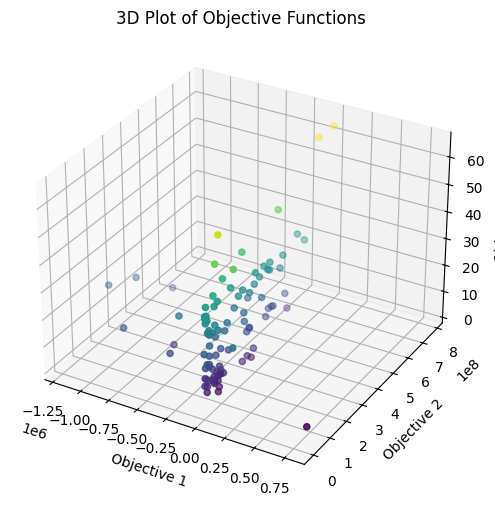

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Generate the final population
pop_size = 100
max_gen = 100
final_population = optimize(pop_size, max_gen)

# Extract the objective function values for each individual in the final population
objective_values = [[objective_function_1(ind), objective_function_2(ind), objective_function_3(ind)] for ind in final_population]

# Plot the objective functions on a 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter([obj[0] for obj in objective_values], [obj[1] for obj in objective_values], [obj[2] for obj in objective_values], c=[obj[2] for obj in objective_values])
ax.set_xlabel('Objective 1')
ax.set_ylabel('Objective 2')
ax.set_zlabel('Objective 3')
ax.set_title('3D Plot of Objective Functions')

plt.show()